In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import pydot

In [2]:
import optuna
import numpy as np
import random
import tensorflow as tf

def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)


/Users/ethan/Desktop/Projet LIONEL/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_excel("/Users/ethan/Desktop/Projet LIONEL/Taux chomage/base de donnée/base_tx_chomage.xlsx",sheet_name="Feuil2")

In [4]:
# 2. Convertir la colonne "Time period" en datetime
df["Time period"] = pd.to_datetime(df["Time period"], format="%Y-%b")



In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

df['Time period'] = pd.to_datetime(df['Time period'], format='%Y-%b')
df.set_index('Time period', inplace=True)

# Paramètres
input_window = 12
output_window = 12
train_countries = ['France', 'Germany', 'Italy', 'Spain', 'United Kingdom']
test_country = 'Greece'

# Préparer les séquences
def create_sequences(data, input_len, output_len):
    X, Y = [], []
    for i in range(len(data) - input_len - output_len + 1):
        x_seq = data[i : i + input_len]
        y_seq = data[i + input_len : i + input_len + output_len]
        X.append(x_seq)
        Y.append(y_seq)
    return np.array(X), np.array(Y)

# Construction du dataset d'entraînement
X_train_list, Y_train_list = [], []
for country in train_countries:
    series = df[country].values
    x, y = create_sequences(series, input_window, output_window)
    X_train_list.append(x)
    Y_train_list.append(y)

X_train = np.concatenate(X_train_list)
Y_train = np.concatenate(Y_train_list)

# Scaler basé uniquement sur pays d'entraînement
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
Y_train_scaled = scaler.transform(Y_train.reshape(-1, 1)).reshape(Y_train.shape)

# Reshape pour LSTM
X_train_scaled = X_train_scaled[..., np.newaxis]
Y_train_scaled = Y_train_scaled[..., np.newaxis]



In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from sklearn.metrics import mean_squared_error

def objective(trial):
    set_seed(42)

    # 🔍 Espace de recherche
    lstm_units = trial.suggest_int("lstm_units", 32, 128)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    recurrent_dropout = trial.suggest_float("recurrent_dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    activation = trial.suggest_categorical("activation", ["tanh", "relu"])
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "rmsprop", "nadam"])
    num_layers = trial.suggest_int("num_layers", 1, 2)

    # 🔧 Optimiseur
    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

    # 🧱 Construction du modèle
    input_seq = Input(shape=(input_window, 1))
    x = LSTM(lstm_units, activation=activation, recurrent_dropout=recurrent_dropout,
             return_sequences=(num_layers == 2))(input_seq)

    if num_layers == 2:
        x = LSTM(lstm_units, activation=activation, return_sequences=False)(x)

    x = RepeatVector(output_window)(x)
    x = LSTM(lstm_units, activation=activation, return_sequences=True)(x)
    x = Dropout(dropout)(x)
    output = TimeDistributed(Dense(1))(x)

    model = Model(inputs=input_seq, outputs=output)
    model.compile(optimizer=optimizer, loss='mse')

    # ⚙ Entraînement
    model.fit(X_train_scaled, Y_train_scaled, epochs=10, batch_size=batch_size, verbose=0)

    # 📈 Prédiction sur la Grèce (stress test)
    last_input_seq = df[test_country].values[-(input_window + output_window):-output_window]
    input_scaled = scaler.transform(last_input_seq.reshape(-1, 1)).reshape(1, input_window, 1)
    pred_scaled = model.predict(input_scaled)
    predicted = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
    true_values = df[test_country].values[-output_window:]

    # 🎯 Métrique à minimiser
    # 🎯 Métrique à minimiser : MAPE
    mape = np.mean(np.abs((true_values - predicted) / np.clip(true_values, 1e-8, None))) * 100
    return mape




Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0402
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0025
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012
Epoch 13/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012
Epoch 14/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015
Epoch 15/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 16/50
61/61 ━

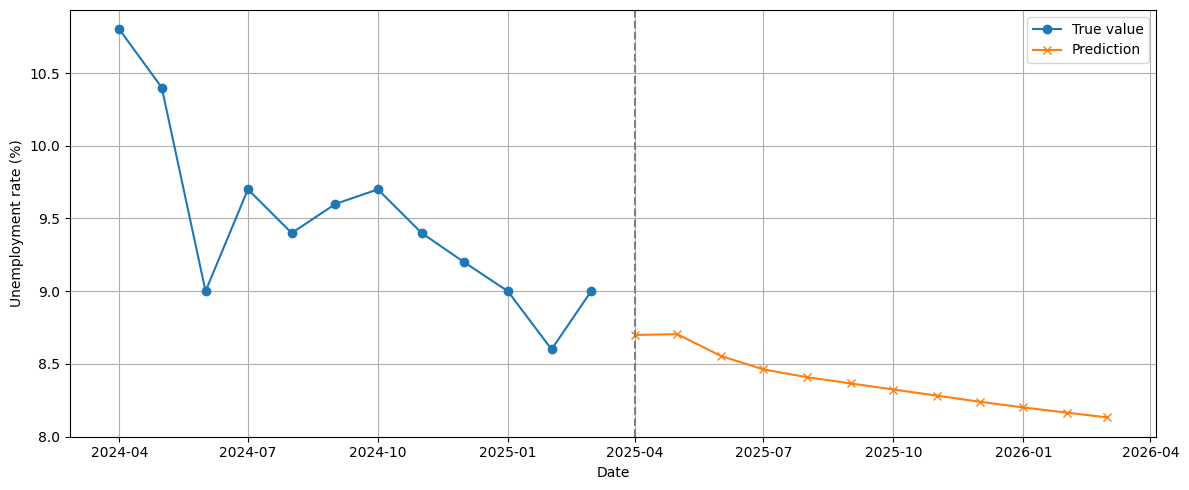

In [7]:
# Construire le modèle
input_seq = Input(shape=(input_window, 1))
encoded = LSTM(64, return_sequences=False)(input_seq)
repeat = RepeatVector(output_window)(encoded)
decoded = LSTM(64, return_sequences=True)(repeat)
output = TimeDistributed(Dense(1))(decoded)
model = Model(inputs=input_seq, outputs=output)
model.compile(optimizer='adam', loss='mse')

# Entraînement
model.fit(X_train_scaled, Y_train_scaled, epochs=50, batch_size=32, verbose=1)

# STRESS TEST sur la Grèce (dernière séquence connue)
greece_series = df[test_country].values
greece_dates = df.index
last_input_seq = greece_series[-(input_window):]
input_scaled = scaler.transform(last_input_seq.reshape(-1, 1)).reshape(1, input_window, 1)
pred_scaled = model.predict(input_scaled)
predicted = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

# Concaténation des vraies valeurs + prédictions
full_sequence = np.concatenate([last_input_seq, predicted])
full_dates = pd.date_range(start=greece_dates[-input_window], periods=input_window + output_window, freq='MS')

# Tracer
plt.figure(figsize=(12, 5))
plt.plot(full_dates[:input_window], last_input_seq, label="True value", marker='o')
plt.plot(full_dates[input_window:], predicted, label="Prediction", marker='x')
plt.axvline(full_dates[input_window], color='gray', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Unemployment rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("🎯 Meilleurs hyperparamètres trouvés :")
print(study.best_params)


[I 2025-06-08 11:36:30,271] A new study created in memory with name: no-name-41e0cee2-0c65-477f-9e6d-dd4a04cf12de


[W 2025-06-08 11:36:36,227] Trial 0 failed with parameters: {'lstm_units': 123, 'dropout': 0.3142583587768236, 'recurrent_dropout': 0.47621674876552816, 'lr': 0.0036063099913695965, 'batch_size': 64, 'activation': 'relu', 'optimizer': 'rmsprop', 'num_layers': 1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/ethan/Desktop/Projet LIONEL/env/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/gm/fq4gxj5n2zq5r3cp7wf4qzk80000gn/T/ipykernel_943/2073700926.py", line 43, in objective
    model.fit(X_train_scaled, Y_train_scaled, epochs=10, batch_size=batch_size, verbose=0)
  File "/Users/ethan/Desktop/Projet LIONEL/env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/Users/ethan/Desktop/Projet LIONEL/env/lib/

KeyboardInterrupt: 

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Comparer aux vraies valeurs de la Grèce sur les 12 mois futurs
true_future_values = df[test_country].values[-output_window:]

# Calcul des métriques
rmse = np.sqrt(mean_squared_error(true_future_values, predicted))
mae = mean_absolute_error(true_future_values, predicted)
mape = np.mean(np.abs((true_future_values - predicted) / np.clip(true_future_values, 1e-8, None))) * 100

print(f"✅ Erreurs sur la Grèce (stress test sur 12 mois) :")
print(f"  RMSE : {rmse:.2f}")
print(f"  MAE  : {mae:.2f}")
print(f"  MAPE : {mape:.2f}%")


✅ Erreurs sur la Grèce (stress test sur 12 mois) :
  RMSE : 1.20
  MAE  : 1.11
  MAPE : 11.41%


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


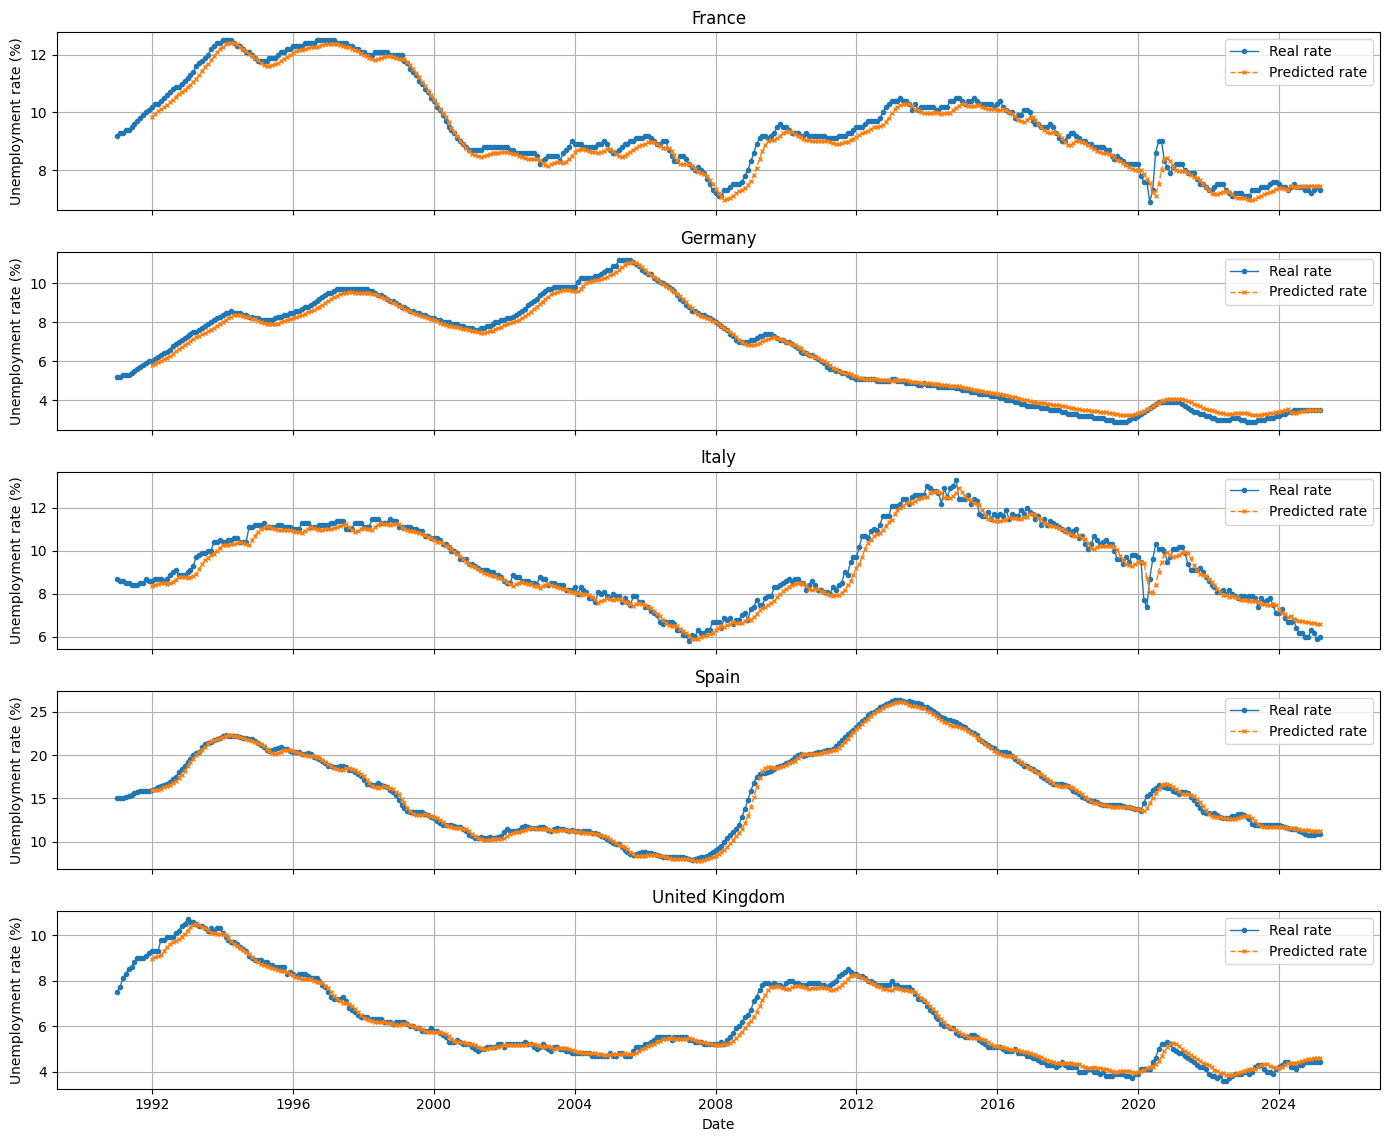

In [12]:
import matplotlib.pyplot as plt

# Pour chaque pays d'entraînement, on reconstruit la série prédites
fig, axes = plt.subplots(len(train_countries), 1, figsize=(14, 12), sharex=True)

for idx, country in enumerate(train_countries):
    series = df[country].values
    dates = df.index

    # Création des séquences
    X_c, Y_c = create_sequences(series, input_window, output_window)
    X_c_scaled = scaler.transform(X_c.reshape(-1, 1)).reshape(X_c.shape)[..., np.newaxis]

    # Prédictions
    Y_pred_scaled = model.predict(X_c_scaled)
    Y_pred = scaler.inverse_transform(Y_pred_scaled.reshape(-1, 1)).reshape(Y_pred_scaled.shape)

    # Reconstruction d'une série temporelle prédite
    pred_series = np.full_like(series, fill_value=np.nan)
    for i in range(len(Y_pred)):
        start = i + input_window
        end = start + output_window
        if end <= len(pred_series):
            pred_series[start:end] = Y_pred[i].flatten()

    ax = axes[idx]
    ax.plot(dates, series, label="Real rate", marker='o', markersize=3, linewidth=1)
    ax.plot(dates, pred_series, label="Predicted rate", linestyle='--', marker='x', markersize=3, linewidth=1)
    ax.set_title(f"{country}")
    ax.set_ylabel("Unemployment rate (%)")
    ax.grid(True)
    ax.legend()

plt.xlabel("Date")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

metrics_summary = []

for country in train_countries:
    series = df[country].values
    X_c, Y_c = create_sequences(series, input_window, output_window)
    X_c_scaled = scaler.transform(X_c.reshape(-1, 1)).reshape(X_c.shape)[..., np.newaxis]

    # Prédiction
    Y_pred_scaled = model.predict(X_c_scaled)
    Y_pred = scaler.inverse_transform(Y_pred_scaled.reshape(-1, 1)).reshape(Y_pred_scaled.shape)

    y_true_flat = Y_c.flatten()
    y_pred_flat = Y_pred.flatten()

    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    mape = np.mean(np.abs((y_true_flat - y_pred_flat) / np.clip(y_true_flat, 1e-8, None))) * 100

    metrics_summary.append({
        'Pays': country,
        'MAE': round(mae, 3),
        'RMSE': round(rmse, 3),
        'MAPE (%)': round(mape, 2)
    })

metrics_df = pd.DataFrame(metrics_summary)
print(metrics_df)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
             Pays    MAE   RMSE  MAPE (%)
0          France  0.340  0.464      3.66
1         Germany  0.292  0.376      4.90
2           Italy  0.400  0.594      4.35
3           Spain  0.762  1.188      4.94
4  United Kingdom  0.303  0.431      5.22


In [79]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Derniers 12 mois réels (vrais taux à comparer)
true_future_values = df[test_country].values[-output_window:]

# Dernière séquence connue pour la Grèce
last_input_seq = df[test_country].values[-(input_window + output_window):-output_window]
input_scaled = scaler.transform(last_input_seq.reshape(-1, 1)).reshape(1, input_window, 1)

# Prédiction sur les 12 mois futurs
pred_scaled = model.predict(input_scaled)
predicted = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

# Calcul des métriques
mae = mean_absolute_error(true_future_values, predicted)
rmse = np.sqrt(mean_squared_error(true_future_values, predicted))
mape = np.mean(np.abs((true_future_values - predicted) / np.clip(true_future_values, 1e-8, None))) * 100

# Affichage
print("📊 Évaluation sur la Grèce (stress test - 12 mois)")
print(f"MAE       : {mae:.3f}")
print(f"RMSE      : {rmse:.3f}")
print(f"MAPE (%)  : {mape:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
📊 Évaluation sur la Grèce (stress test - 12 mois)
MAE       : 1.792
RMSE      : 1.911
MAPE (%)  : 19.39
